# Classificazione dei coralli usando metodi supervisionati e non supervisionati

L'obiettivo di questo progetto è di classificare immagini di coralli in base alle loro caratteristiche utilizzando sia metodi supervisionati che non supervisionati per poi confrontare le prestazioni dei due approcci.

## Introduzione

I coralli sono organismi che vivono in mare e sono molto importanti per la biodiversità e la salute del mare. Avere un sistema per classificare i coralli in base alle loro caratteristiche è molto utile per velocizzare il processo degli specialisti degli oceani, soprattutto se utilizzassimo un modello non supervisionato che eviterebbe il processo di etichettare ogni immagine dei coralli.

# Imports

In [163]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.feature import local_binary_pattern
from mahotas.features import haralick
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

## Estrazione delle feature

In questa sezione trasformiamo le immagini da RGB a livelli di grigio per poi utilizzare l'algoritmo `Gray-Level Co-occurence Matrix` (GLCM) per estrarre le texture feature e memorizzarle in un dataframe.

In [164]:
train_folder = "REEF_DATASET/EILAT/"
features_list = []         # Lista per le feature
ground_truth_labels_list = [] # lista per le etichette di ground truth

valid_image_extensions = ('.jpg')
# Loop through i numeri delle directory (gli interi da 1 a 8)
for directory_label in range(1, 9):
    sub_folder_name_only = f"A0{directory_label}" 
    current_sub_folder_path = os.path.join(train_folder, sub_folder_name_only)

    if not os.path.isdir(current_sub_folder_path):
        print(f"Warning: Directory {current_sub_folder_path} not found. Skipping.")
        continue

    try:
        image_filenames_in_dir = [
            f for f in os.listdir(current_sub_folder_path)
            if os.path.isfile(os.path.join(current_sub_folder_path, f)) and \
               f.lower().endswith(valid_image_extensions)
        ]
    except OSError as e:
        print(f"Error: Could not list files in directory {current_sub_folder_path}: {e}. Skipping.")
        continue
        
    if not image_filenames_in_dir:
        print(f"Warning: No valid image files found in {current_sub_folder_path}. Skipping.")
        continue

    for image_filename in tqdm(image_filenames_in_dir, desc=f"Processing {sub_folder_name_only}"):
        image_path = os.path.join(current_sub_folder_path, image_filename)

        image = cv2.imread(image_path) 

        if image is None:
            print(f"Warning: Failed to load image {image_path}. Skipping.")
            continue

        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # LOCAL BINARY PATTERNS
        radius = 2
        n_points = 8 * radius
        lbp_image = local_binary_pattern(image_gray, n_points, radius, method='uniform')
        
        n_bins = int(lbp_image.max() + 1)
        lbp_hist, _ = np.histogram(lbp_image.ravel(), density=True, bins=n_bins, range=(0, n_bins))

        # HARALICK FEATURES
        haralick_features_matrix = haralick(image_gray) 
        b = haralick_features_matrix.mean(axis=0) 
        
        current_features = {
            'lbp_hist': lbp_hist.tolist(),
            'haralick': b.tolist(),
        }

        features_list.append(current_features)
        ground_truth_labels_list.append(directory_label)

df = pd.DataFrame(features_list)
true_labels = np.array(ground_truth_labels_list) - 1 

print(f"DataFrame creato con {len(df)} campioni.")
print(f"Array di ground truth 'true_labels' creato con {len(true_labels)} etichette.")


Processing A08: 100%|██████████| 77/77 [00:00<00:00, 221.30it/s]

DataFrame creato con 1123 campioni.
Array di ground truth 'true_labels' creato con 1123 etichette.


In [165]:
df

,lbp_hist,haralick
0,"[0.094482421875, 0.052734375, 0.04248046875, 0...","[0.001112548267838469, 134.17850351946333, 0.5..."
1,"[0.091552734375, 0.04150390625, 0.0419921875, ...","[0.0006610736677567364, 112.92101678634413, 0...."
2,"[0.093994140625, 0.0537109375, 0.043701171875,...","[0.0014958984489034858, 96.74236662257493, 0.5..."
3,"[0.114990234375, 0.0537109375, 0.036865234375,...","[0.00035153062099511326, 263.91843919280666, 0..."
4,"[0.0869140625, 0.046875, 0.043212890625, 0.037...","[0.0009869730765262707, 112.9504814657344, 0.7..."
...,...,...
1118,"[0.0556640625, 0.0322265625, 0.035888671875, 0...","[0.0005286024960256381, 126.9292662666918, 0.9..."
1119,"[0.07470703125, 0.038818359375, 0.044189453125...","[0.0003552699896083975, 369.6750047241117, 0.8..."
1120,"[0.06396484375, 0.03369140625, 0.038330078125,...","[0.00037329185261422395, 320.3060811130007, 0...."
1121,"[0.061767578125, 0.031005859375, 0.04077148437...","[0.0010450532994024553, 51.27440495874274, 0.8..."


# Visualizzazione


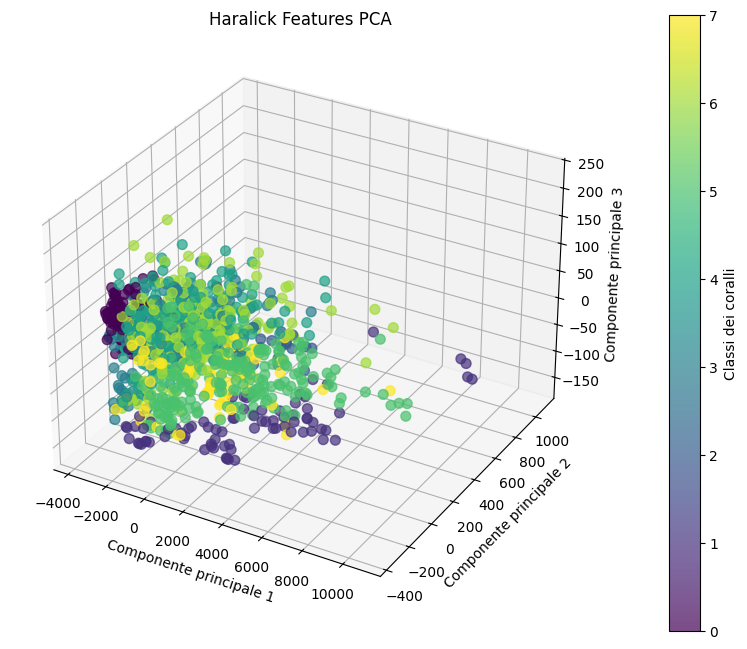

In [166]:
pca_3d = PCA(n_components=3, random_state=42)

haralick_data_for_pca = np.array(df["haralick"].tolist())

X_pca_3d = pca_3d.fit_transform(haralick_data_for_pca)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter_data = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                           s=50, alpha=0.7, c=true_labels, cmap='viridis')

ax.set_title('Haralick Features PCA')
ax.set_xlabel('Componente principale 1')
ax.set_ylabel('Componente principale 2')
ax.set_zlabel('Componente principale 3')

cbar = fig.colorbar(scatter_data, ax=ax, pad=0.1)
cbar.set_label('Classi dei coralli')

plt.show()

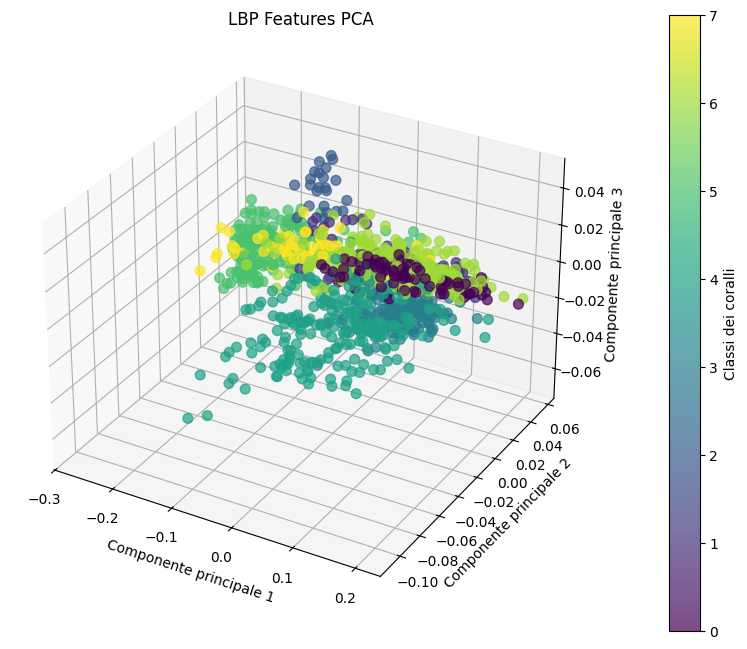

In [167]:
pca_3d = PCA(n_components=3, random_state=42)

lbp_data_for_pca = np.array(df["lbp_hist"].tolist())

X_pca_3d = pca_3d.fit_transform(lbp_data_for_pca)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter_data = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                            s=50, alpha=0.7, c=true_labels, cmap='viridis')

ax.set_title('LBP Features PCA')
ax.set_xlabel('Componente principale 1')
ax.set_ylabel('Componente principale 2')
ax.set_zlabel('Componente principale 3')

cbar = fig.colorbar(scatter_data, ax=ax, pad=0.1)
cbar.set_label('Classi dei coralli')

plt.show()

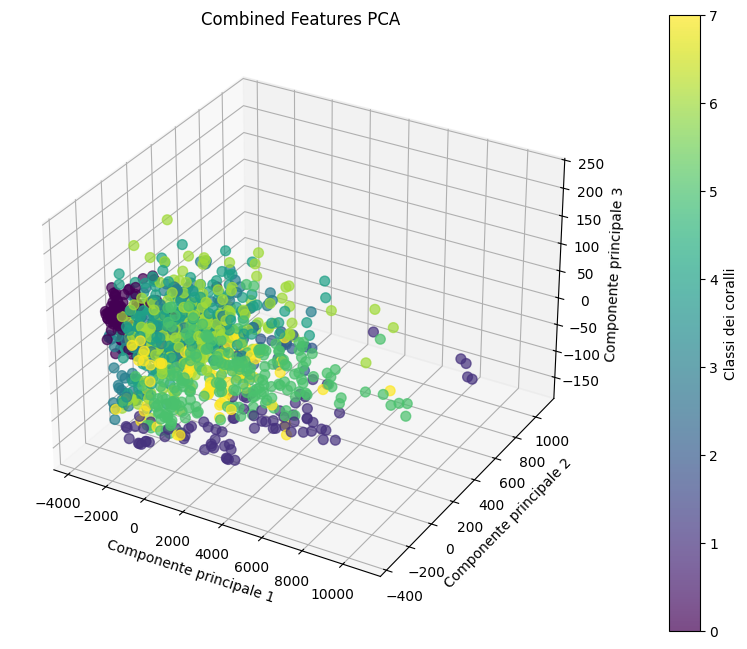

In [168]:
pca_3d = PCA(n_components=3, random_state=42)

combined_features_for_pca = np.concatenate((lbp_data_for_pca, haralick_data_for_pca), axis=1)

X_pca_3d = pca_3d.fit_transform(combined_features_for_pca)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter_data = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                            s=50, alpha=0.7, c=true_labels, cmap='viridis')

ax.set_title('Combined Features PCA')
ax.set_xlabel('Componente principale 1')
ax.set_ylabel('Componente principale 2')
ax.set_zlabel('Componente principale 3')

cbar = fig.colorbar(scatter_data, ax=ax, pad=0.1)
cbar.set_label('Classi dei coralli')

plt.show()

# Supervised Learning

Per quanto riguarda la parte supervisionata utilizzerò un modello di Logistic Regression multi-classe

In [169]:
df['true_labels'] = true_labels
df

,lbp_hist,haralick,true_labels
0,"[0.094482421875, 0.052734375, 0.04248046875, 0...","[0.001112548267838469, 134.17850351946333, 0.5...",0
1,"[0.091552734375, 0.04150390625, 0.0419921875, ...","[0.0006610736677567364, 112.92101678634413, 0....",0
2,"[0.093994140625, 0.0537109375, 0.043701171875,...","[0.0014958984489034858, 96.74236662257493, 0.5...",0
3,"[0.114990234375, 0.0537109375, 0.036865234375,...","[0.00035153062099511326, 263.91843919280666, 0...",0
4,"[0.0869140625, 0.046875, 0.043212890625, 0.037...","[0.0009869730765262707, 112.9504814657344, 0.7...",0
...,...,...,...
1118,"[0.0556640625, 0.0322265625, 0.035888671875, 0...","[0.0005286024960256381, 126.9292662666918, 0.9...",7
1119,"[0.07470703125, 0.038818359375, 0.044189453125...","[0.0003552699896083975, 369.6750047241117, 0.8...",7
1120,"[0.06396484375, 0.03369140625, 0.038330078125,...","[0.00037329185261422395, 320.3060811130007, 0....",7
1121,"[0.061767578125, 0.031005859375, 0.04077148437...","[0.0010450532994024553, 51.27440495874274, 0.8...",7


Ora che abbiamo il dataframe contenente le features e le etichette di ground truth, possiamo procedere con la sua visualizzazione.

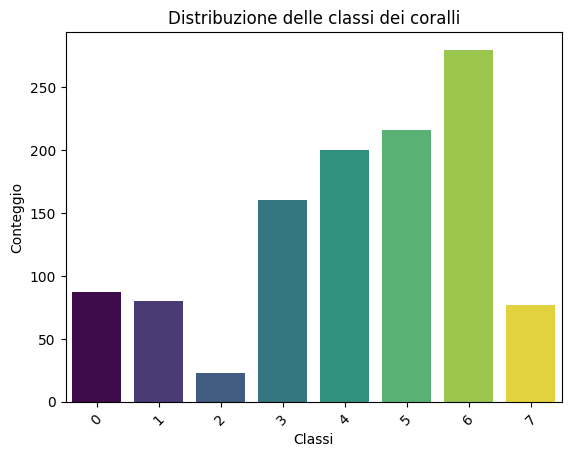

In [170]:
sns.countplot(x='true_labels', data=df, hue='true_labels', palette='viridis', legend=False)
plt.title('Distribuzione delle classi dei coralli')
plt.xlabel('Classi')
plt.ylabel('Conteggio')
plt.xticks(rotation=45)
plt.show()

In [171]:

features_combined = np.concatenate((lbp_data_for_pca, haralick_data_for_pca), axis=1)
features_lbp = np.array(df["lbp_hist"].tolist())
features_haralick = np.array(df["haralick"].tolist())
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(features_combined, df['true_labels'], test_size=0.2, random_state=42, shuffle=True)
X_train_LBP, X_test_LBP, y_train_LBP, y_test_LBP = train_test_split(features_LBP, df['true_labels'], test_size=0.2, random_state=42, shuffle=True)
X_train_haralick, X_test_haralick, y_train_haralick, y_test_haralick = train_test_split(features_haralick, df['true_labels'], test_size=0.2, random_state=42, shuffle=True)

Dobbiamo scalare le feature perche' è importante per la performance del modello.

In [172]:
st_x = StandardScaler()
X_train_combined = st_x.fit_transform(X_train_combined)
X_test_combined = st_x.transform(X_test_combined)
X_train_LBP = st_x.fit_transform(X_train_LBP)
X_test_LBP = st_x.transform(X_test_LBP)
X_train_haralick = st_x.fit_transform(X_train_haralick)
X_test_haralick = st_x.transform(X_test_haralick)

Definisco una funzione per calcolare il miglior solver multi-classe

In [173]:
def logistic_model(C, solver_):
    logistic_regression_model = LogisticRegression(random_state=42, solver=solver_, n_jobs=1, C=C, max_iter=5000)
    return logistic_regression_model

Text(0.5, 1.0, 'Beans Accuracy')

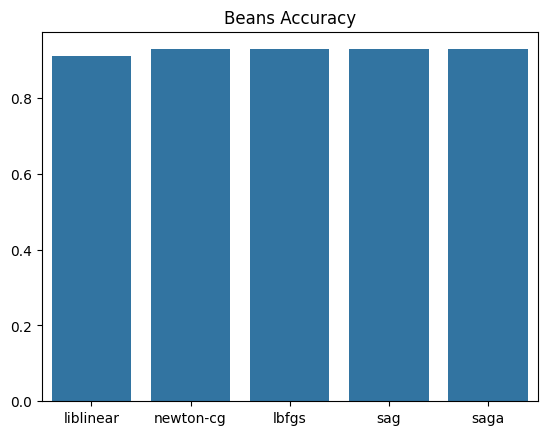

In [174]:
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
scores = []
params = []

for i in solver_list:
        try:
            model = logistic_model(10, i)
            model.fit(X_train_combined, y_train_combined)
            predictions = model.predict(X_test_combined)
            params.append(i)
            accuracy = accuracy_score(y_test_combined, predictions)
            scores.append(accuracy)
        except:
            print(f"Solver {i} ha generato un errore/warning: {e}")


sns.barplot(x=params, y=scores).set_title('Beans Accuracy')


In [175]:
print(f"Numero di classi uniche in y_train: {len(np.unique(y_train_combined))}")
print(f"Classi uniche: {np.unique(y_train_combined)}")

solver_accuracy = []
print("Scores ottenuti:")
for solver_name, score_val in zip(params, scores):
    print(f"  Solver: {solver_name}, Accuracy: {score_val:.6f}")
    solver_accuracy.append((solver_name, score_val))


Numero di classi uniche in y_train: 8
Classi uniche: [0 1 2 3 4 5 6 7]
Scores ottenuti:
  Solver: liblinear, Accuracy: 0.911111
  Solver: newton-cg, Accuracy: 0.928889
  Solver: lbfgs, Accuracy: 0.928889
  Solver: sag, Accuracy: 0.928889
  Solver: saga, Accuracy: 0.928889


A questo punto, usando il miglior solver, per ciascun dataframe (combinazione di feature, solo harlick e solo LBP) creo il modello e lo addestro.

Successivamente, calcolo le metriche e la matrice di confusione per ogni modello per poi paragonarlo con il modello nullo.

Definiamo le etichette per l'importanza delle feature.

In [176]:
n_lbp_features = lbp_data_for_pca.shape[1] # Number of LBP features
n_haralick_features = haralick_data_for_pca.shape[1] # Number of Haralick features

feature_names_lbp = [f'LBP_{i}' for i in range(n_lbp_features)]
if n_haralick_features == 13:
    feature_names_haralick = [
        'Angular Second Moment', 'Contrast', 'Correlation', 'Sum of Squares', 
        'Inverse Difference Moment', 'Sum Average', 'Sum Variance', 'Sum Entropy', 
        'Entropy', 'Difference Variance', 'Difference Entropy', 
        'Info Measure Corr 1', 'Info Measure Corr 2' 
    ]
else:
    # Fallback to generic names if not the standard 13
    feature_names_haralick = [f'Haralick_{i}' for i in range(n_haralick_features)]
all_feature_names = feature_names_lbp + feature_names_haralick # This is the 'features' list

Definisco funzioni per evitare codice ridondante.

In [207]:
solver = max(solver_accuracy, key=lambda x: x[1])
print(f"Best solver: {solver[0]}, Accuracy: {solver[1]:.6f}")
def prediction(X_train, y_train, X_test):
    model = logistic_model(1, solver[0])
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return model, predictions

def confusion_matrix_display(y_test, predicts):
    cm = confusion_matrix(y_test, predicts)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

def classification_report_display(y_test, predicts):
    class_labels_for_report = [f"A0{i+1}" for i in sorted(np.unique(y_test))]

    report_dict = classification_report(y_test, predicts, output_dict=True, target_names=class_labels_for_report)
    report_df = pd.DataFrame(report_dict).iloc[:-1, :].T    

    metrics_to_plot = ['precision', 'recall', 'f1-score']
    report_df_filtered = report_df[metrics_to_plot]

    plt.figure(figsize=(10, 7))
    sns.heatmap(report_df_filtered, annot=True, fmt=".2f", cmap="viridis")
    plt.title('Classification Report Heatmap')
    plt.xlabel('Metriche')
    plt.ylabel('Classi dei coralli')
    plt.tight_layout()
    plt.show()
    return metrics.accuracy_score(y_test, predicts)

def feature_importance_display(model, feature_names):
    
    # Importanza delle Feature
    importance_col_name_for_plot = "" 

    if hasattr(model, 'coef_'):
        coefficients = model.coef_

        if len(feature_names) != coefficients.shape[1]:
            print(f"Error: Mismatch! Number of feature names ({len(feature_names)}) "
                f"does not match number of model coefficients ({coefficients.shape[1]}).")
            print("Ensure 'feature_names' accurately reflects the features the model was trained on.")
            feature_importance_df = None 
        else:
            if coefficients.shape[0] == 1: 
                feature_importance_values = coefficients[0]
                feature_importance_df = pd.DataFrame({
                    'Feature': feature_names, 
                    'Importance': feature_importance_values
                })
                feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
                importance_col_name_for_plot = 'Importance'
            else: 
                
                avg_abs_coeffs = np.mean(np.abs(coefficients), axis=0)
                feature_importance_df = pd.DataFrame({
                    'Feature': feature_names, 
                    'Average Absolute Importance': avg_abs_coeffs
                })
                feature_importance_df = feature_importance_df.sort_values(by='Average Absolute Importance', ascending=False)
                importance_col_name_for_plot = 'Average Absolute Importance'

            if feature_importance_df is not None:

                plt.figure(figsize=(10, 8)) 
                top_n_to_display = 10 
                sns.barplot(
                    x=importance_col_name_for_plot, 
                    y='Feature', 
                    data=feature_importance_df.head(top_n_to_display), 
                    palette='viridis',
                    hue=importance_col_name_for_plot, 
                    dodge=False 
                )
                plt.title(f'Top {top_n_to_display} Feature Importances (Coefficients)')
                plt.tight_layout()
                plt.show()


Best solver: newton-cg, Accuracy: 0.928889


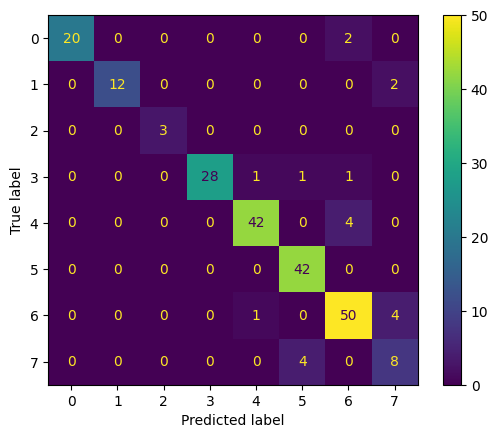

In [208]:
model, predictions = prediction(X_train_combined, y_train_combined, X_test_combined)
confusion_matrix_display(y_test_combined, predictions)

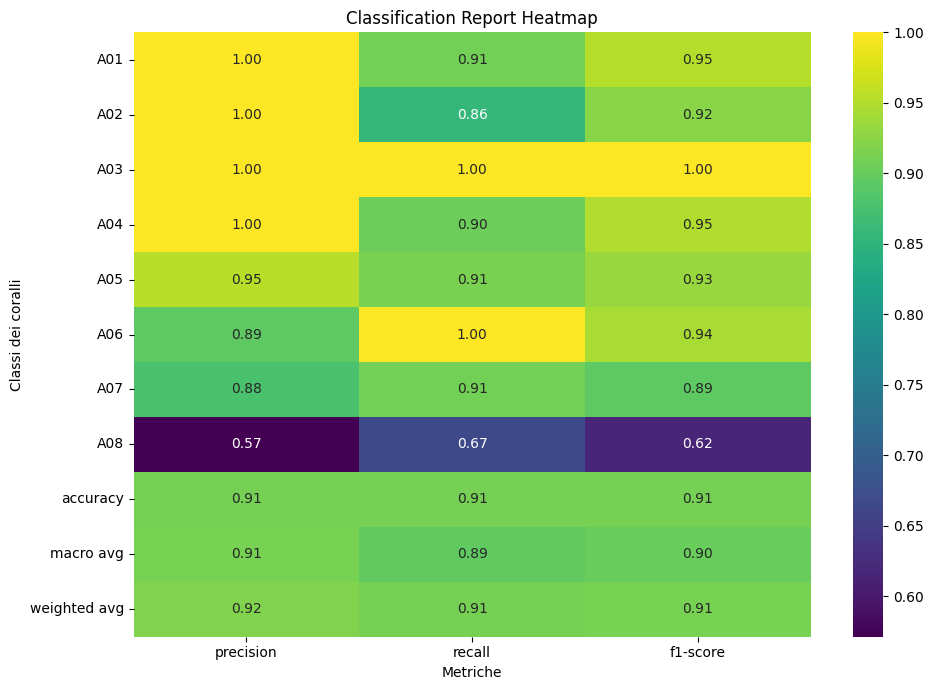

In [209]:
accuracy_combined = classification_report_display(y_test_combined, predictions)


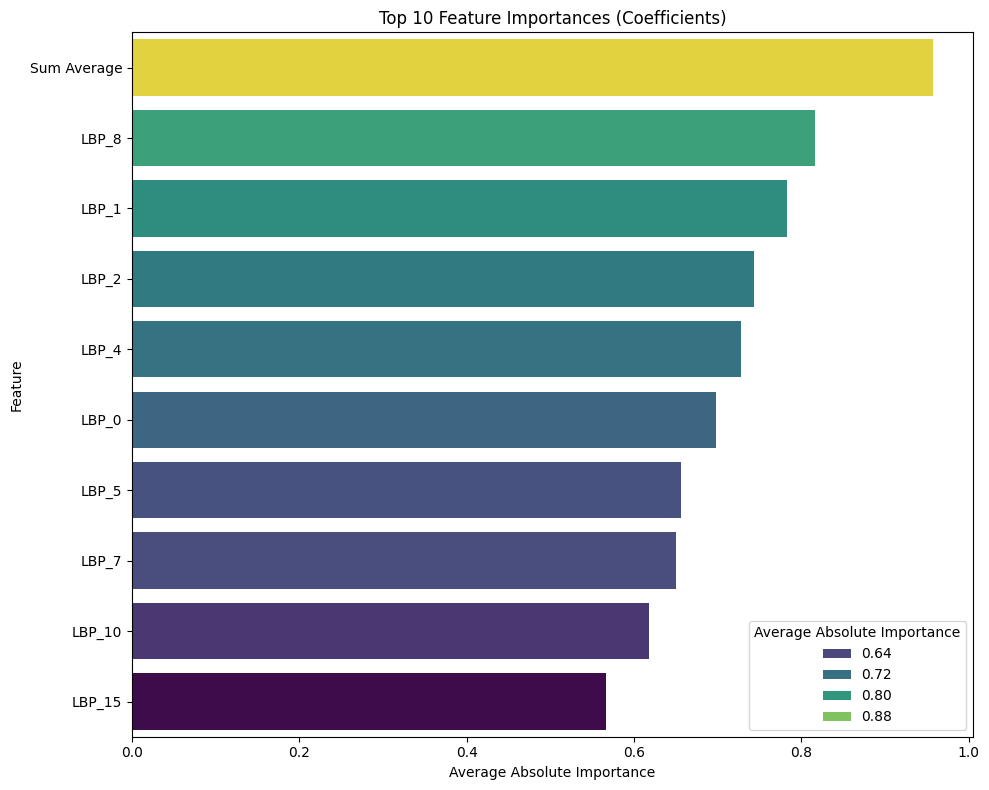

In [210]:
feature_importance_display(model, all_feature_names)

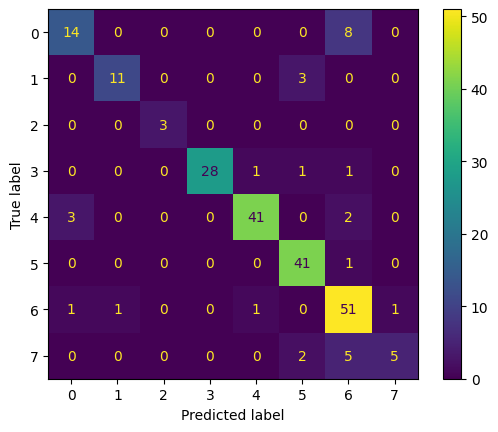

In [211]:
model, predictions = prediction(X_train_LBP, y_train_LBP, X_test_LBP)
confusion_matrix_display(y_test_LBP, predictions)

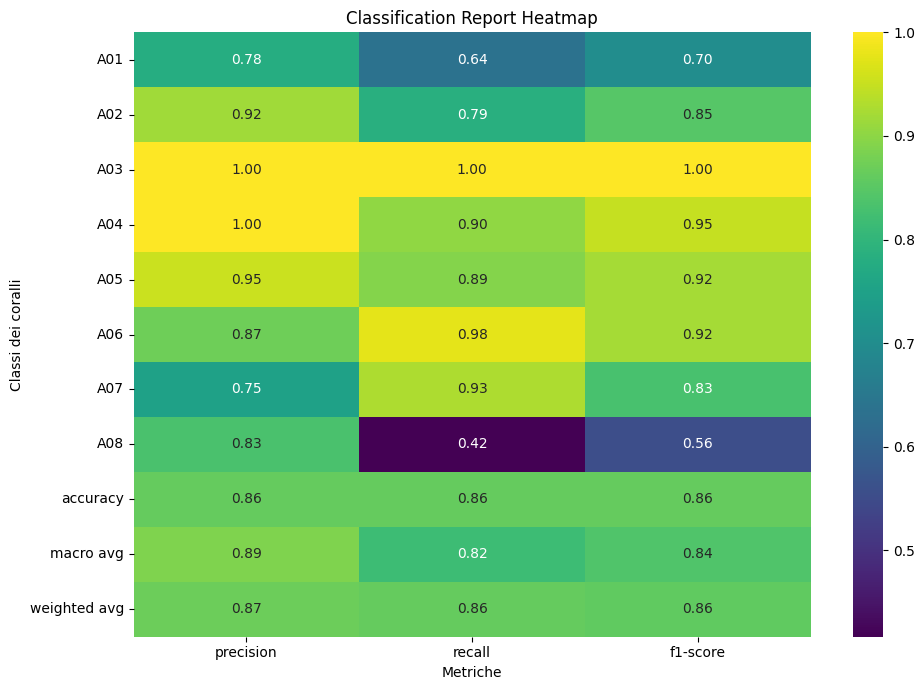

In [212]:
accuracy_LBP = classification_report_display(y_test_LBP, predictions)

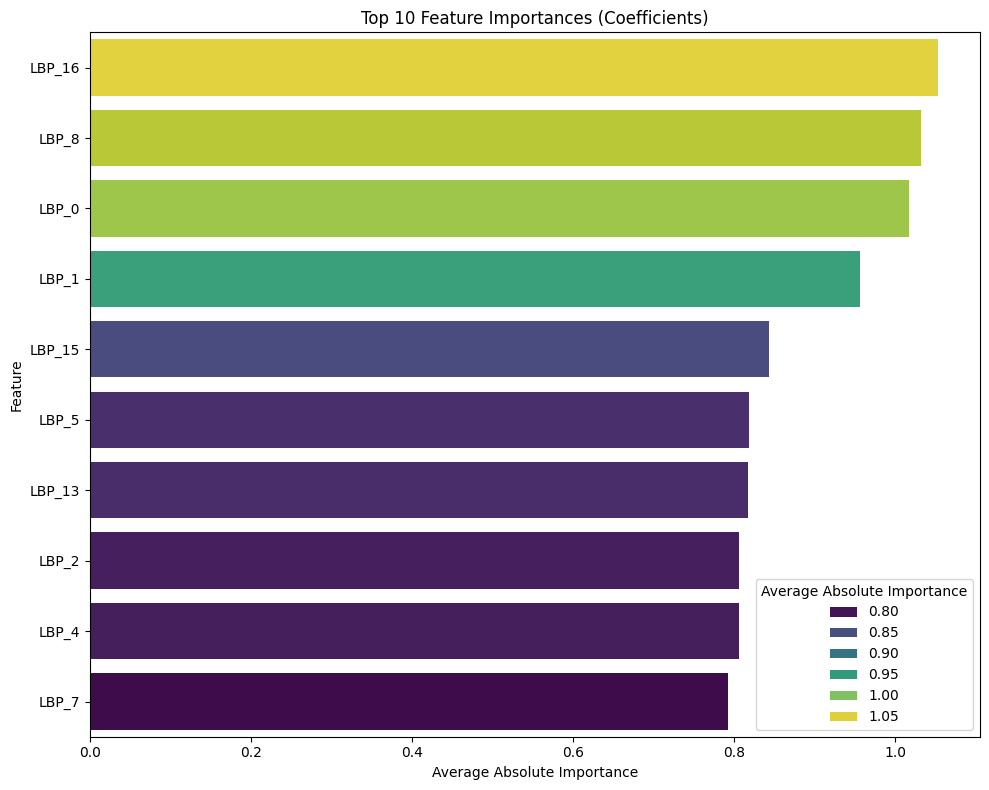

In [213]:
feature_importance_display(model, feature_names_lbp)

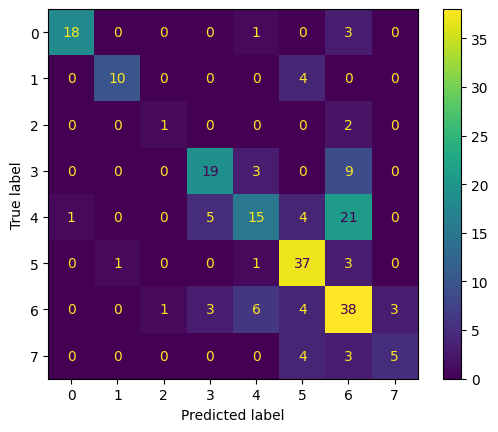

In [214]:
model, predictions = prediction(X_train_haralick, y_train_haralick, X_test_haralick)
confusion_matrix_display(y_test_haralick, predictions)

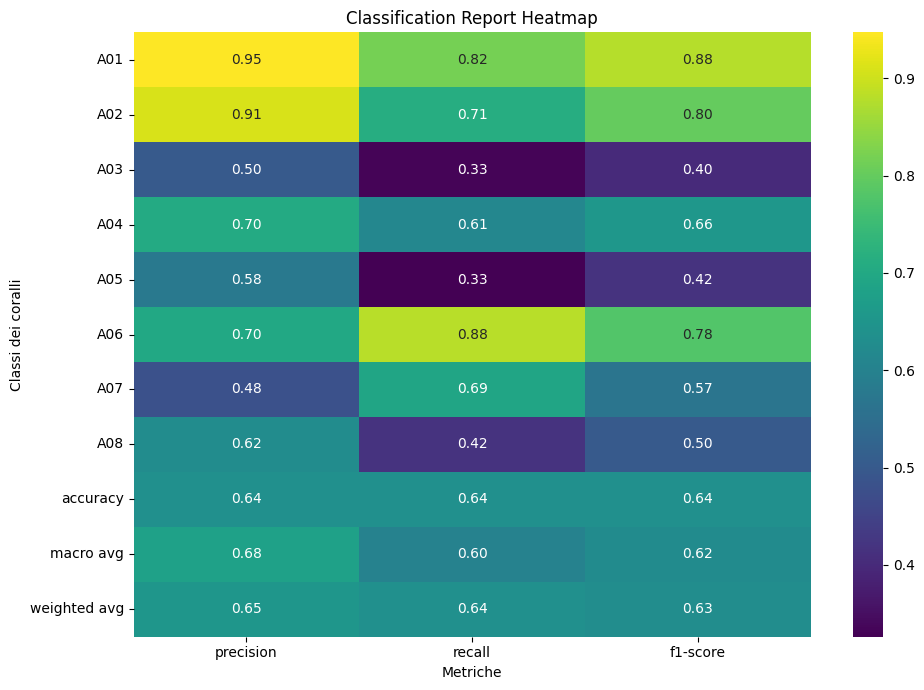

In [215]:
accuracy_haralick = classification_report_display(y_test_haralick, predictions)

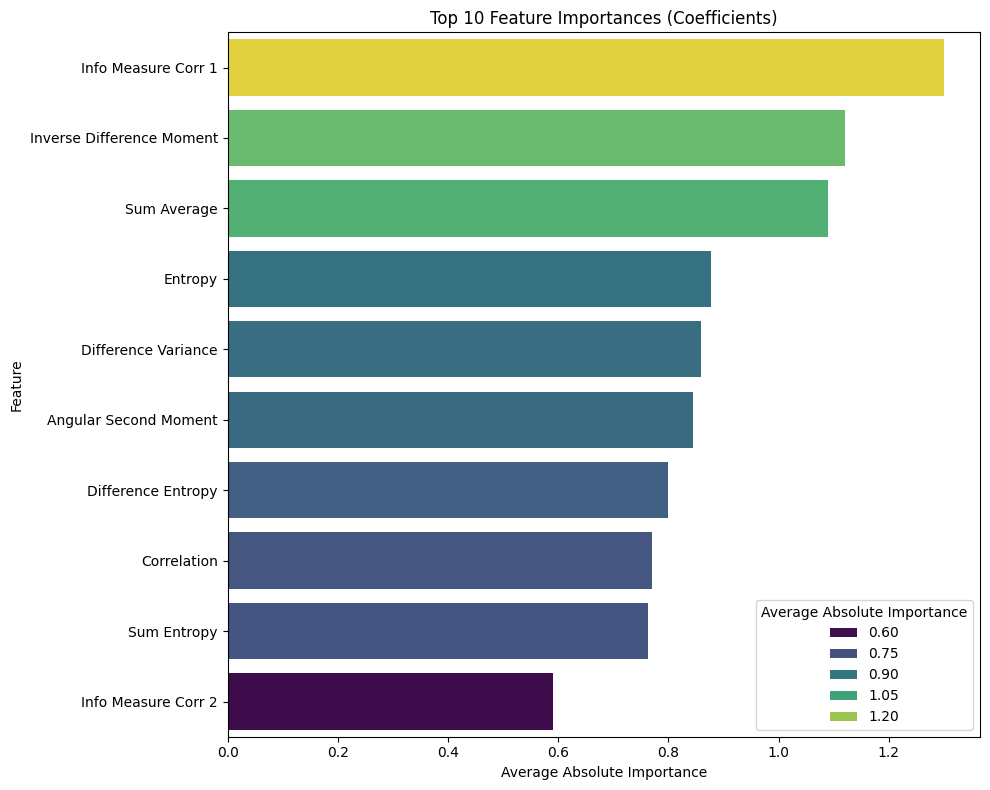

In [216]:
feature_importance_display(model, feature_names_haralick)

# Modello nullo

Accuracy Null Model: 0.2493321460373998


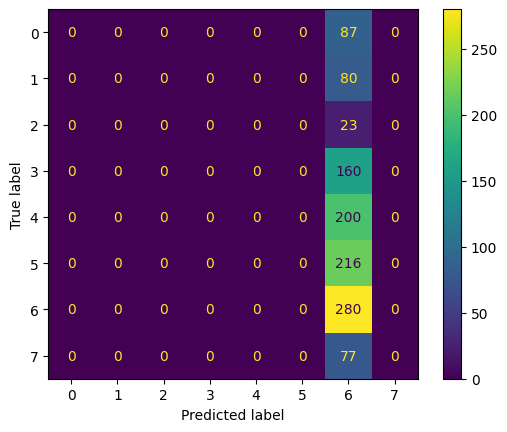

In [217]:

null_model_y = np.full(len(true_labels), 6)
cm = metrics.confusion_matrix(true_labels, null_model_y)
accuracy_null = metrics.accuracy_score(true_labels, null_model_y)
print("Accuracy Null Model:", accuracy_null)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7])
disp.plot()
plt.show()

Adesso confrontiamo l'accuracy dei tre modelli con il modello nullo

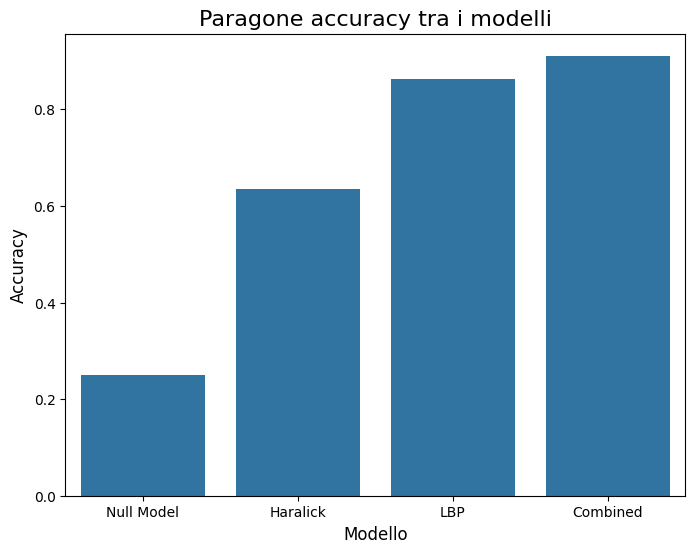

In [220]:
accuracies = [accuracy_null, accuracy_haralick, accuracy_LBP, accuracy_combined]
x_labels = ["Null Model", "Haralick", "LBP", "Combined"]

plt.figure(figsize=(8, 6))
barplot = sns.barplot(x=x_labels, y=accuracies)

plt.title('Paragone accuracy tra i modelli', fontsize=16)
plt.xlabel('Modello', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.show()

## Fonti
- https://github.com/sbianco78/UnsupervisedPlanktonLearning
- LBP: https://scikit-image.org/docs/0.24.x/auto_examples/features_detection/plot_local_binary_pattern.html
- LBP: https://arxiv.org/html/2407.18665v1
- Haralick: https://www.haralick.org/journals/TexturalFeatures.pdf
- PCA: https://www.ibm.com/it-it/think/topics/principal-component-analysis
- Logistic Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Logistic Regression: https://danhergir.medium.com/implementing-multi-class-logistic-regression-with-scikit-learn-53d919b72c13